In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

PATTERN_SIZE=(9, 6)

In [3]:
def load_calibration(filename):
    '''
    Loads a saved calibration
    '''
    contents = pickle.load(open(filename, 'rb'))
    return contents['camera_matrix'], contents['distortion_coefficients']
    
def calibrate(images_glob, pattern_size, draw_corners_path=None, save_calibration_filename=None):
    '''
    Return calibration values for the images found in images_glob
    '''
    object_points = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    object_points[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1,2)

    all_object_points = []
    all_image_points = []
    img_size = None

    for index, filename in enumerate(images_glob):
        image = cv2.imread(filename)
        
        if img_size is None:
            img_size = (image.shape[1], image.shape[0])
        if img_size[0] != image.shape[1] or img_size[1] != image.shape[0]:
            raise Exception('Image size should be the same for all images')

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        ret, found_corners = cv2.findChessboardCorners(gray, pattern_size, None)
        if ret == False:
            continue

        all_object_points.append(object_points)
        all_image_points.append(found_corners)

        if draw_corners_path is not None:
            cv2.drawChessboardCorners(image, pattern_size, found_corners, ret)
            write_name = draw_corners_path + '/corners_found' + str(index + 1) + '.jpg'
            cv2.imwrite(write_name, image)
            
    _, camera_matrix, distortion_coefficients, _, _ = cv2.calibrateCamera(
        all_object_points, 
        all_image_points, 
        img_size, 
        None, 
        None
    )    
    
    if save_calibration_filename is not None:
        contents = {}
        contents['camera_matrix'] = camera_matrix
        contents['distortion_coefficients'] = distortion_coefficients        
        pickle.dump(contents, open(save_calibration_filename, 'wb'))
    return _, camera_matrix, distortion_coefficients, _, _

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

try:
    camera_matrix, distortion_coefficients = load_calibration('calibration.p')
    print('Loaded saved calibration file')
except FileNotFoundError:
    print('No saved calibration file found, re-calibrating...')
    _, camera_matrix, distortion_coefficients, _, _ = calibrate(
        images,  
        pattern_size=PATTERN_SIZE, 
        draw_corners_path='chessboards', 
        save_calibration_filename='calibration.p'
    )
    print('Regenerated and saved calibration')

Loaded saved calibration file


In [5]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == False:
        return None, None
    
    # If we found corners, draw them! (just for fun)
    cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([
        corners[0], 
        corners[nx - 1], 
        corners[-1], 
        corners[-nx]
    ])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([
        [offset, offset], 
        [img_size[0] - offset, offset], 
        [img_size[0] - offset, img_size[1] - offset], 
        [offset, img_size[1] - offset]
    ])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

In [ ]:
for index, filename in enumerate(images):
    img = cv2.imread(filename)
    img_size = (img.shape[1], img.shape[0])
    # warped = cv2.undistort(img, mtx, dist, None, mtx)
    warped, M = corners_unwarp(img, PATTERN_SIZE[0], PATTERN_SIZE[1], camera_matrix, distortion_coefficients)
    
    if warped is None:
        continue
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
def shift_perspective(image, source_points, destination_points):
    image_size = (image.shape[1], image.shape[0])
    matrix = cv2.getPerspectiveTransform(source_points, destination_points)
    warped = cv2.warpPerspective(image, matrix, image_size)
    return warped

def warp_birds_eye(image):
    '''
    Shift perspective in image from looking down the road to a bird's-eye
    view above the camera looking straight down.
    '''
    (h, w) = (image.shape[0], image.shape[1])
    source_points = np.float32([
        [w / 2 - 76, h * .625], 
        [w / 2 + 76, h * .625], 
        [-100, h], 
        [w + 100, h]
    ])
    destination_points = np.float32([
        [100, 0], 
        [w - 100, 0], 
        [100, h], 
        [w - 100, h]
    ])    
    return shift_perspective(image, source_points, destination_points)

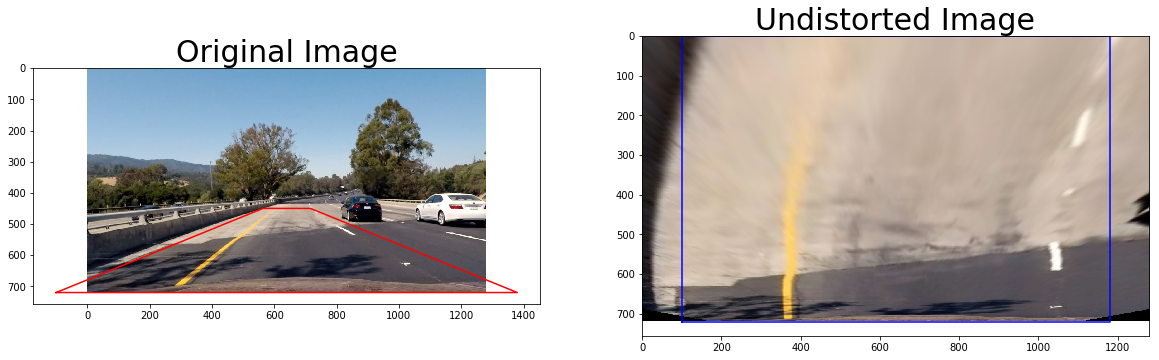

In [68]:
filename = 'test4'
image = cv2.imread('test_images/' + filename + '.jpg')
undistorted = cv2.undistort(image, camera_matrix, distortion_coefficients, None)
cv2.imwrite('test_images/processed/' + filename + '_undistorted.jpg', undistorted)
transformed_image = warp_birds_eye(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

(h, w) = (image.shape[0], image.shape[1])
source_points = np.float32([
    [-100, h], 
    [w / 2 - 76, h * .625],
    [w / 2 + 76, h * .625], 
    [w + 100, h],
    [-100, h], 
])
ax1.plot(*zip(*source_points), 'r-')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))

destination_points = np.float32([
    [100, h], 
    [100, 0],
    [w - 100, 0], 
    [w - 100, h],
    [100, h], 
])    
ax2.plot(*zip(*destination_points), 'b-')


ax2.set_title('Undistorted Image', fontsize=30)

In [8]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def apply_thresholds(image):
    ksize = 3

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0 * np.pi / 180, 10 * np.pi / 180))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return gradx, grady, mag_binary, dir_binary, combined

In [10]:
gradx, grady, mag_binary, dir_binary, combined = apply_thresholds(undistorted)

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(18, 24))

axes[0][0].set_title('Original Image', fontsize=30)
axes[0][1].set_title('Sobel', fontsize=30)

input_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB)] * 5
sobel_images = [gradx, grady, mag_binary, dir_binary, combined]
for images, column in zip([input_images, sobel_images], axes.T):
    for img, ax in zip(images, column):
        ax.imshow(img, cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

NameError: name 'undistorted' is not defined

In [ ]:
gradx, grady, mag_binary, dir_binary, combined = apply_thresholds(transformed_image)

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(18, 24))

axes[0][0].set_title('Perspective Shifted Image', fontsize=30)
axes[0][1].set_title('Sobel', fontsize=30)

input_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB)] * 5
sobel_images = [gradx, grady, mag_binary, dir_binary, combined]
for images, column in zip([input_images, sobel_images], axes.T):
    for img, ax in zip(images, column):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout(pad=0.1)

In [11]:
def filter_image(image, l_thresh=(230, 255), b_thresh=(145, 255), sx_thresh=(20, 100)):
    '''
    Thresholds an image based on Sobel gradient in the x direction, the L-channel
    in an LUV colorspace, and the B-channel in a LAB colorspace. Returns a mask
    with pixel values of 0 or 1 based on accepted thresholded values.
    '''
    (h, w) = (image.shape[0], image.shape[1])
    image = np.copy(image)[:, 100:w-100, :]
    
    luv = cv2.cvtColor(image, cv2.COLOR_BGR2Luv).astype(np.float)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab).astype(np.float)
    l_channel = luv[:,:,0]
    b_channel = lab[:,:,2]
    
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( l_binary, sxbinary, b_binary))    
    mask = np.zeros_like(color_binary)
    mask[ (color_binary[:,:,0] > 0) | (color_binary[:,:,1] > 0) | (color_binary[:,:,2] > 0) ] = 1
    
    return mask[:,:,0][:,:,None]

In [12]:

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def sliding_window(image):
    # Read in a thresholded image
    warped = np.copy(image)
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    return output

In [13]:
def pipeline(image):
    undistorted = cv2.undistort(image, camera_matrix, distortion_coefficients, None)
    filtered = filter_image(undistorted)
    warped = warp_birds_eye(filtered)
        
    return warped


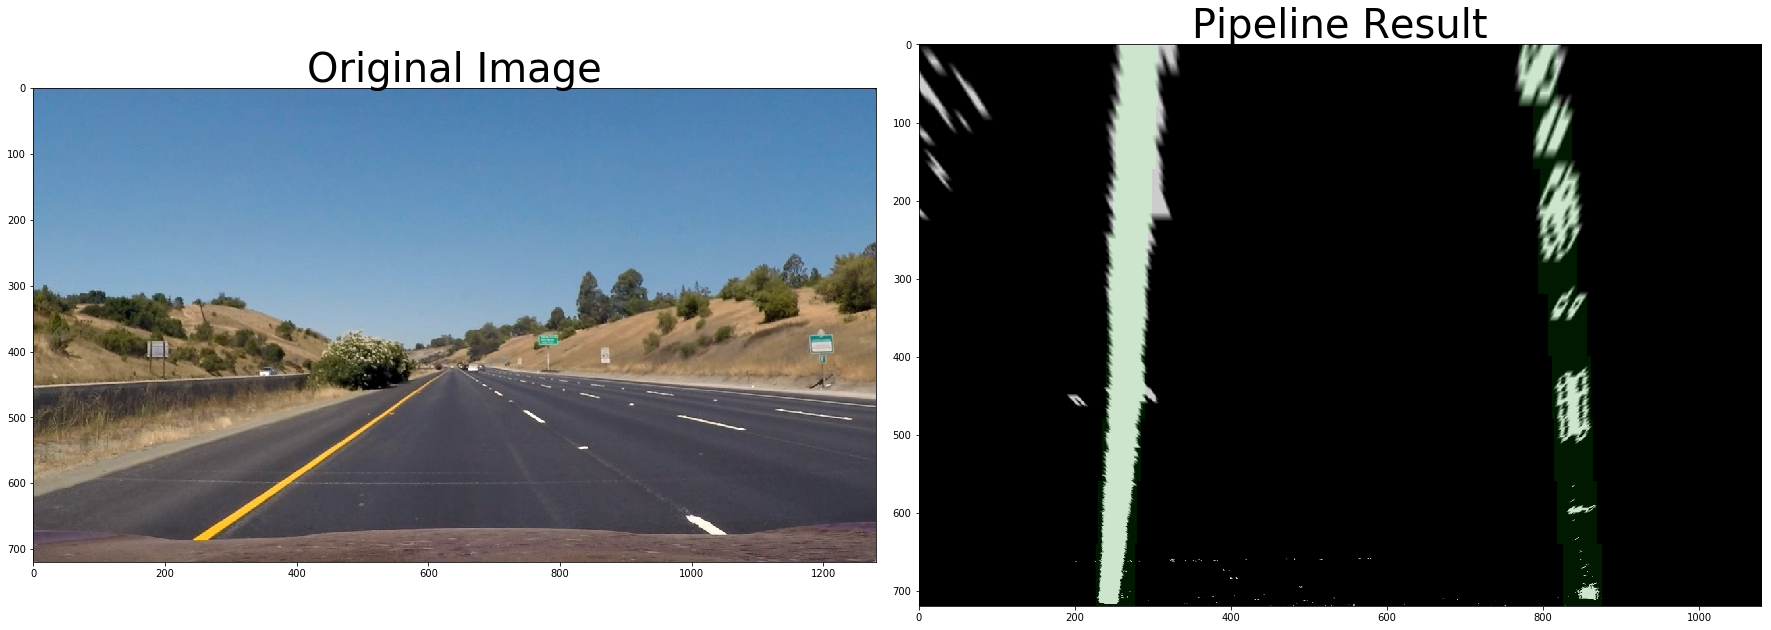

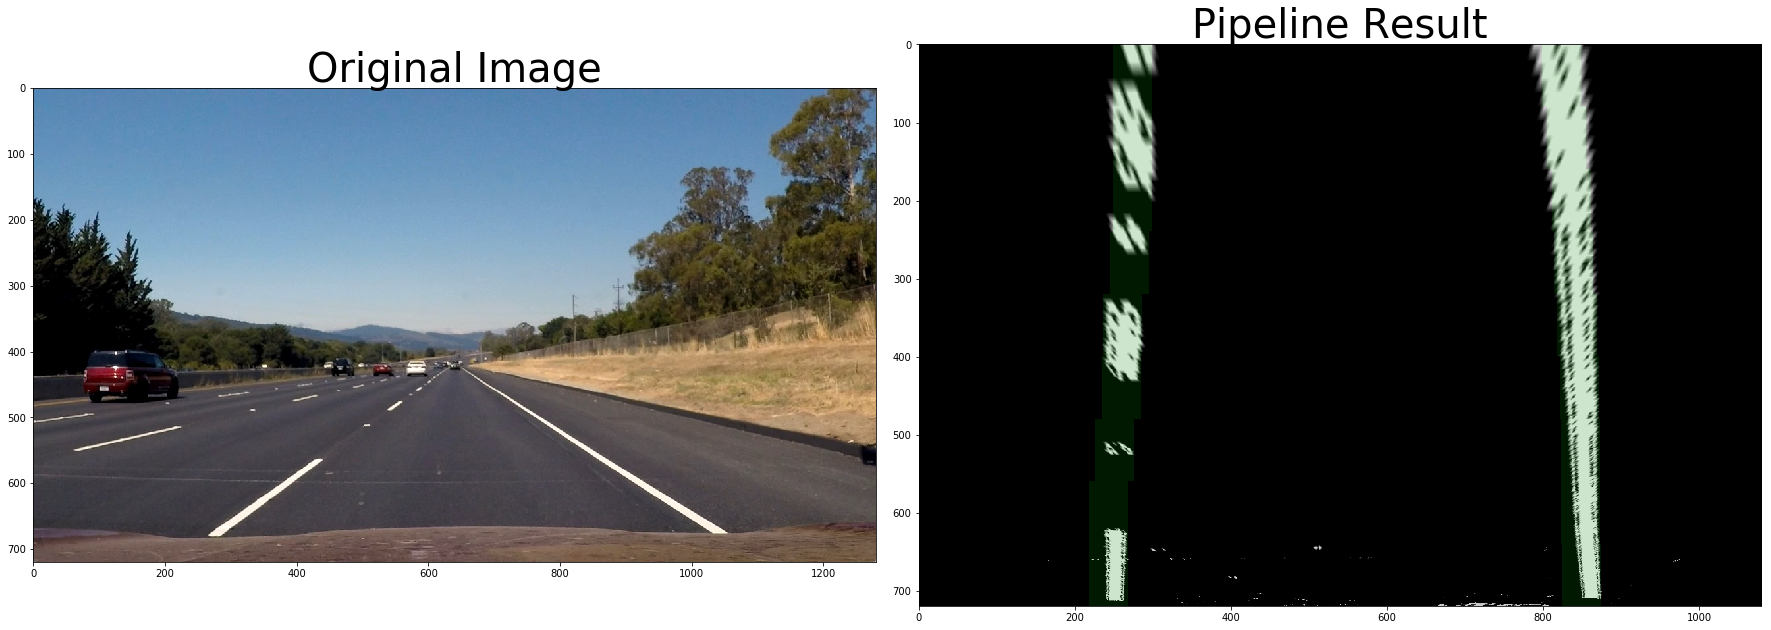

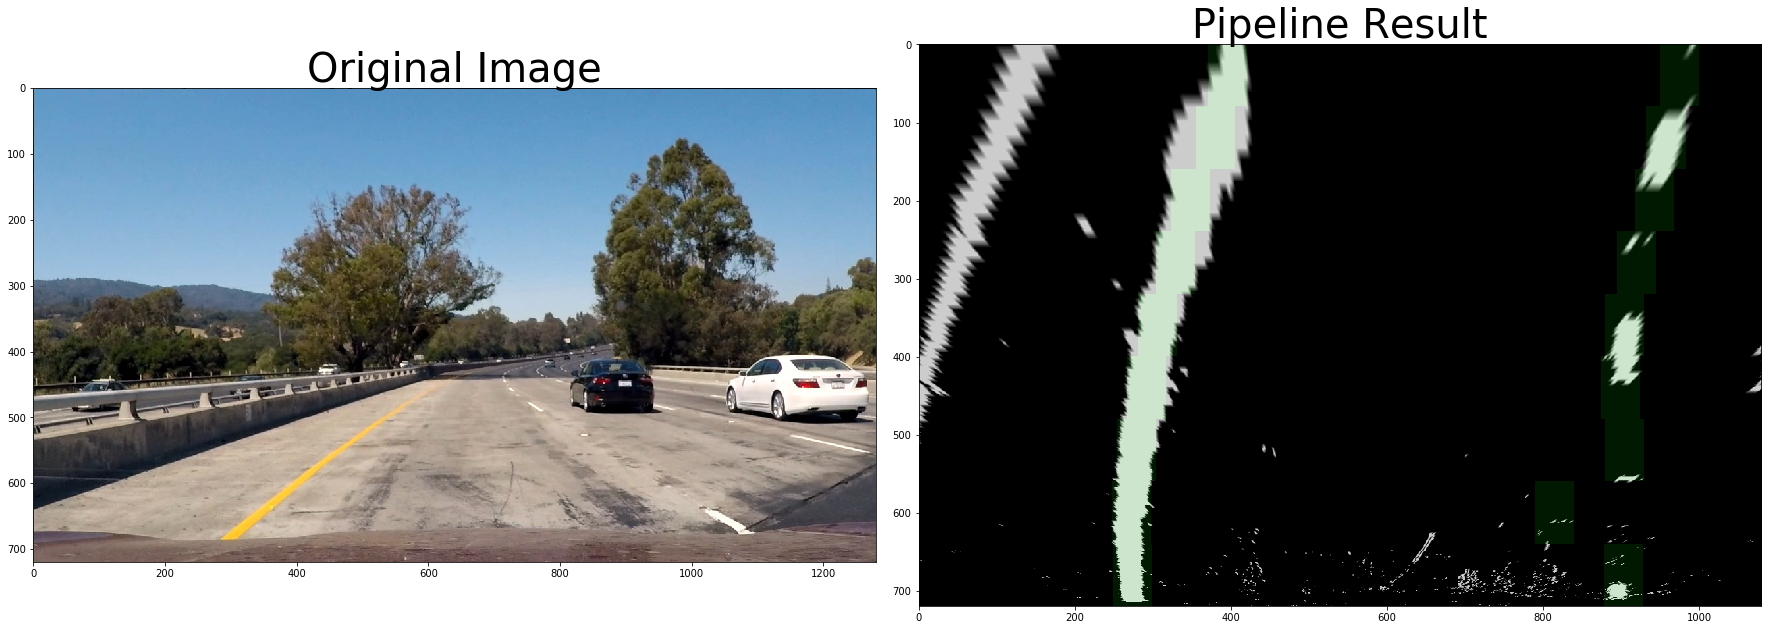

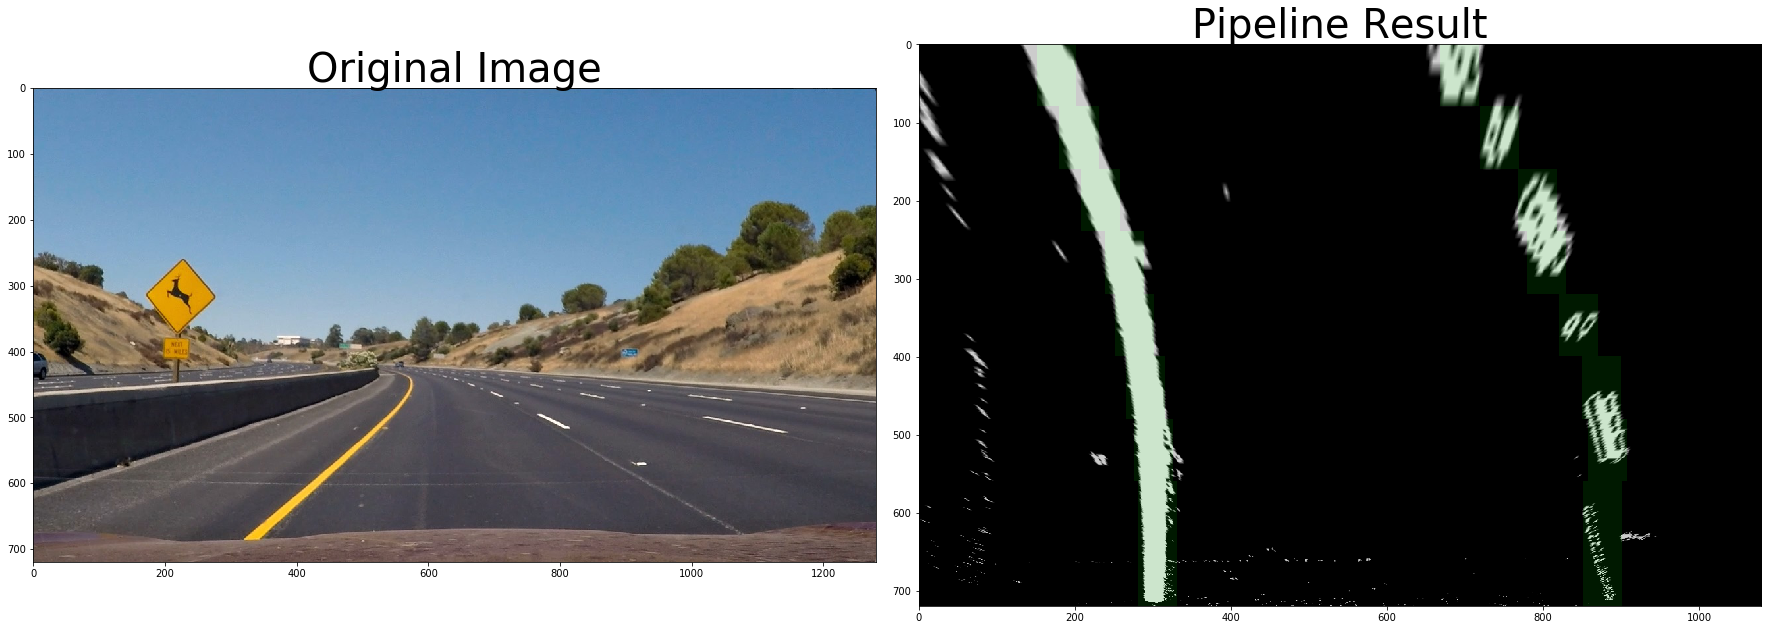

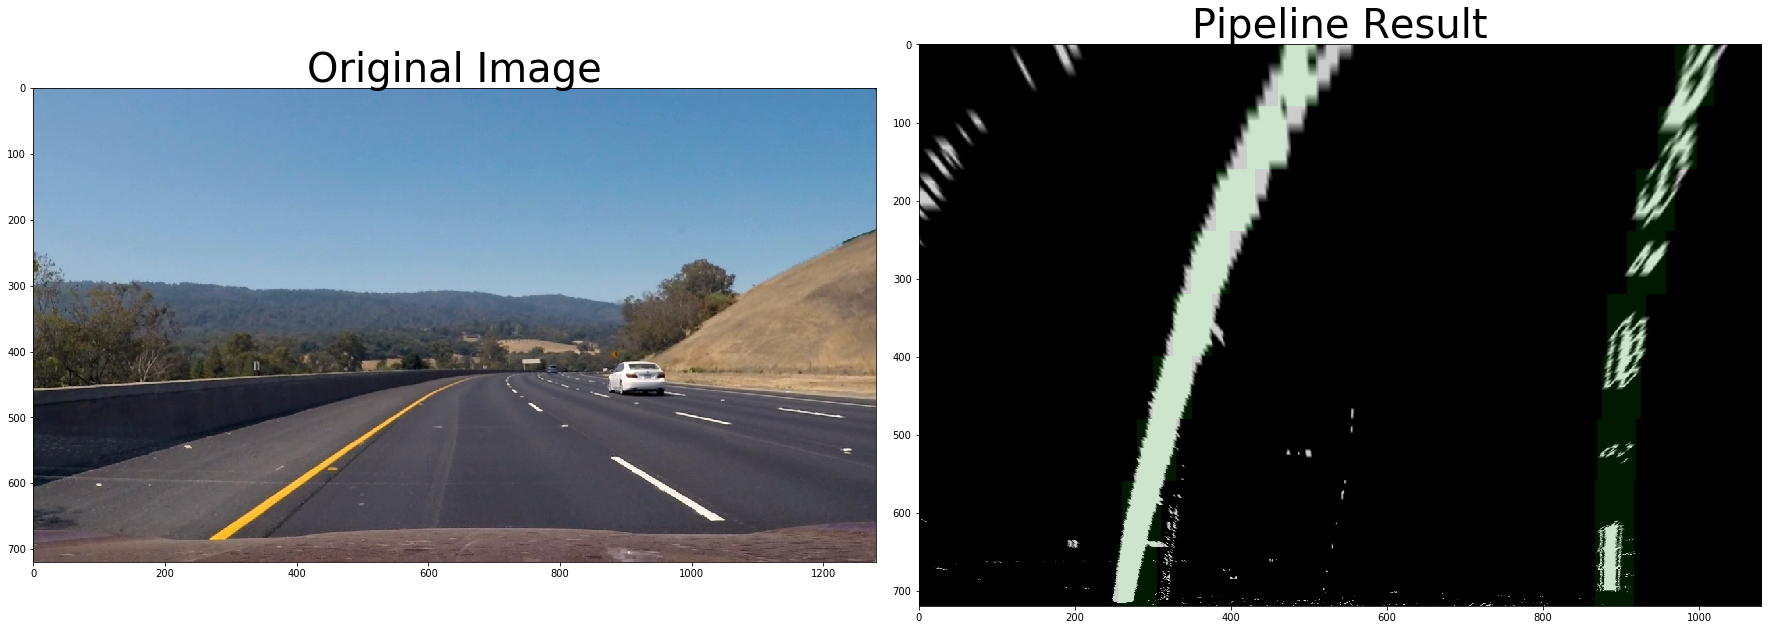

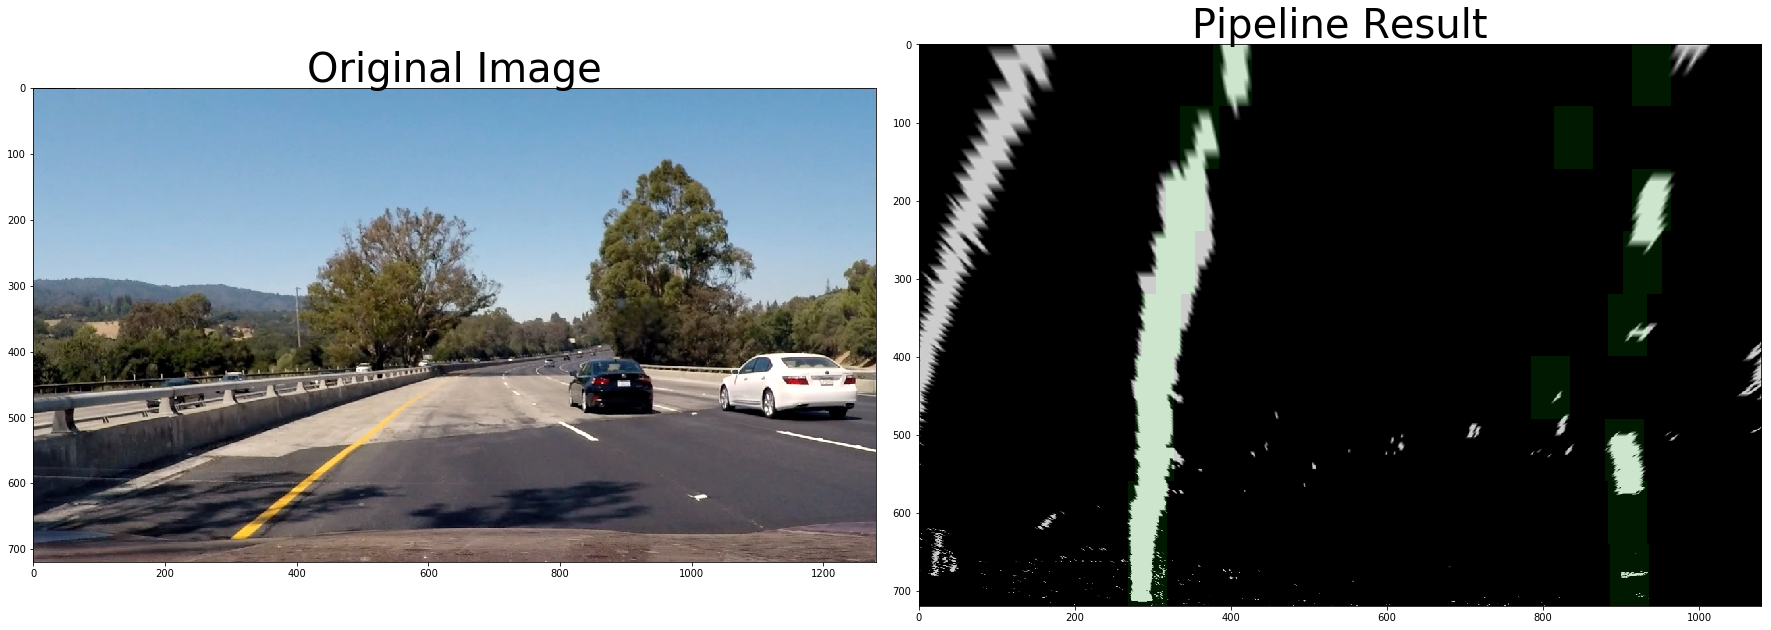

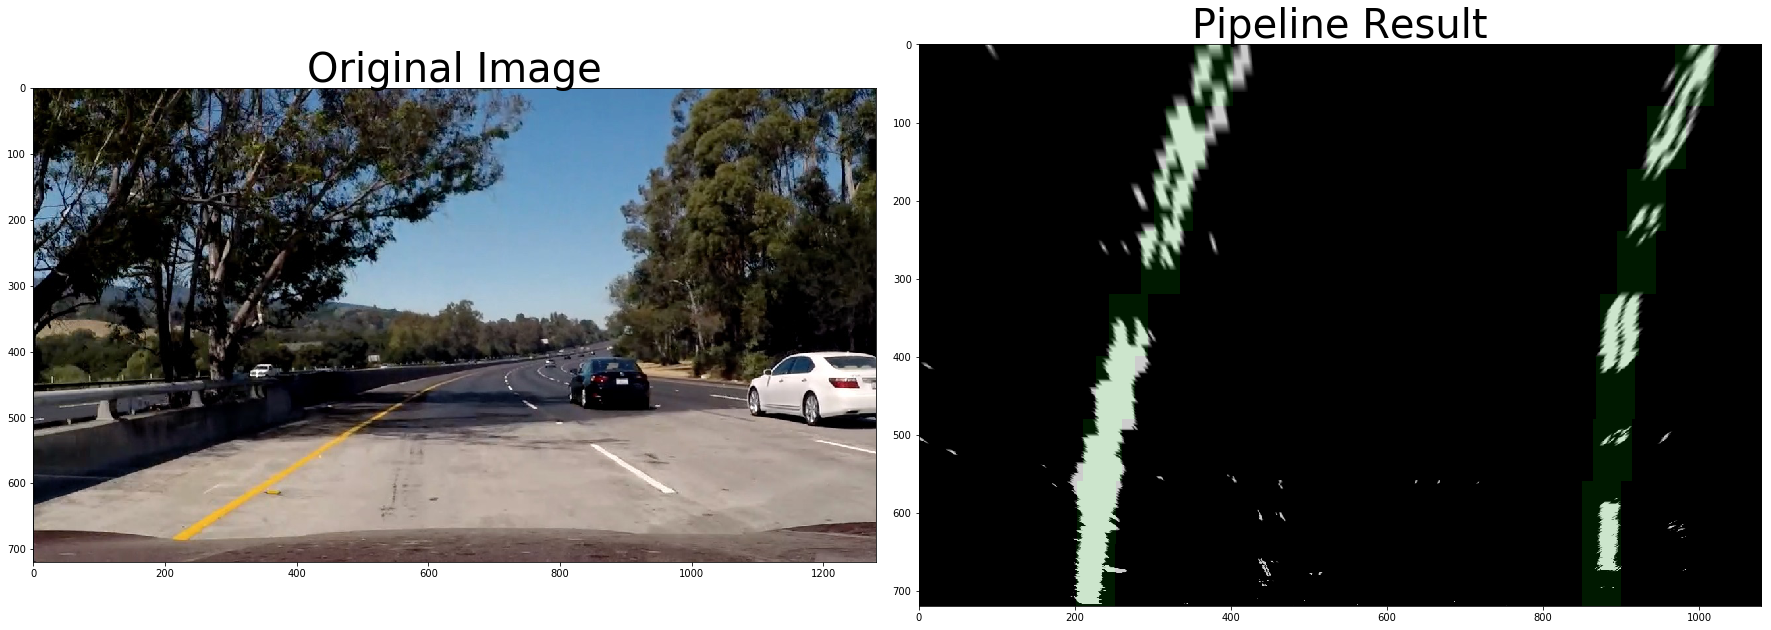

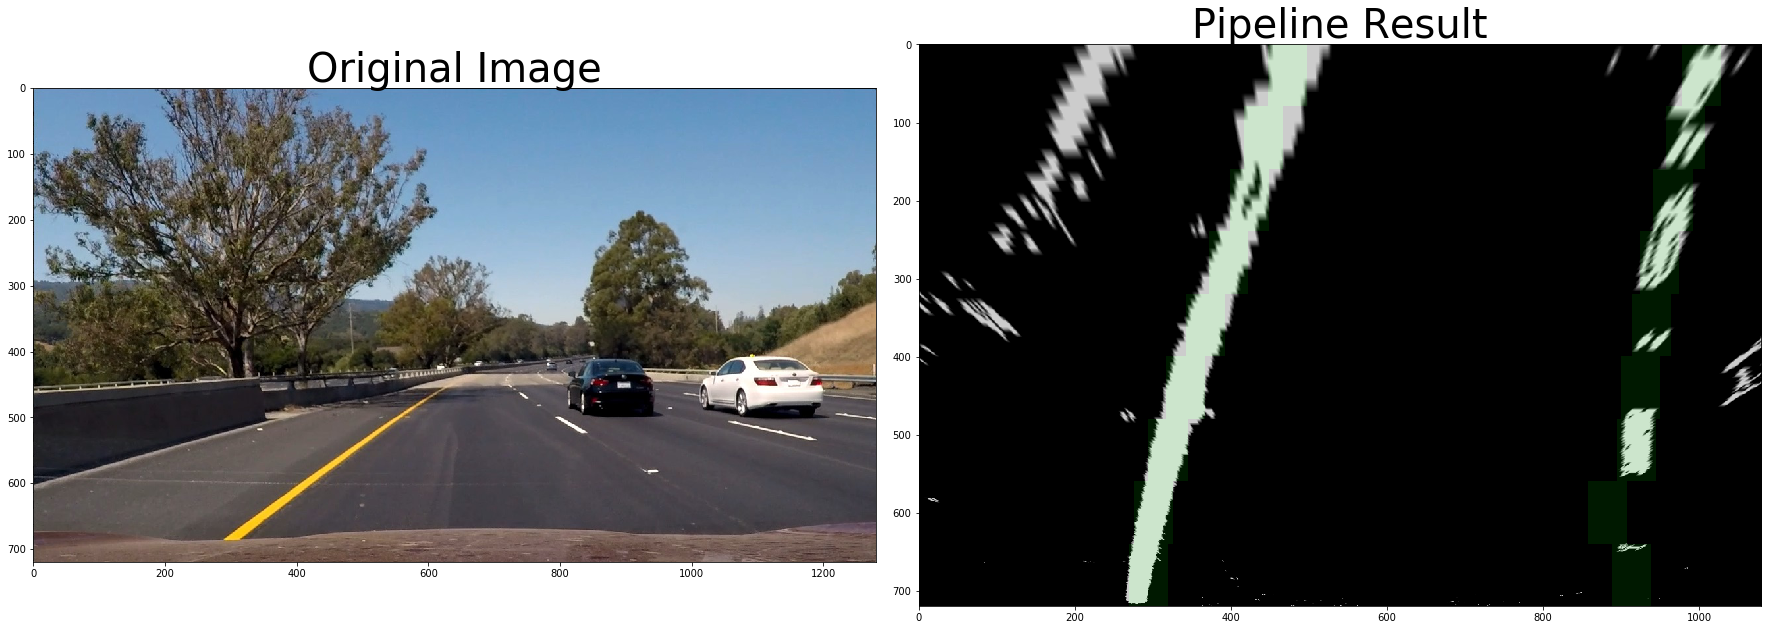

In [14]:
filenames = glob.glob('test_images/*.jpg')

for image in [ cv2.imread(filename) for filename in filenames ]:
    result = pipeline(image)
    window = sliding_window(result)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 24))
    f.tight_layout()

    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=40)
    ax2.imshow(result, cmap='gray')
    ax2.imshow(window, cmap='gray', alpha=0.2)
    ax2.set_title('Pipeline Result', fontsize=40)
    
#     histogram = result.shape[0] - np.sum(result[np.int(result.shape[0] * 3/4):,:], axis=0)
#     ax2.plot(histogram, "y-", lw=4)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [31]:

from PIL import Image

def merge_images(np_image1, np_image2):
    image1 = Image.fromarray(np.uint8(np_image1))
    image2 = Image.fromarray(np.uint8(np_image2))

    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    
    return np.array(result)


def process_image(gf, t):
    image = gf(t)
    result = pipeline(image)
    window = sliding_window(result)

    return merge_images(image, window)


from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:23<00:00,  4.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 32s, sys: 1min 16s, total: 4min 49s
Wall time: 4min 24s
